# Generate Semantic Similarity Network at TOP level 

### load data

In [1]:
import json

with open('../../data/speeches_20.jsonl', 'r', encoding='utf8') as fp:
    data = list(fp)
speeches = []
for line in data:
    speeches.append(json.loads(line))

### import local utilities and other libs

In [53]:
import os
import sys
module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)

from utilities.BTTools import filter_for
from utilities.BTTools import groupSpeechesByDiscussionTitle

# other stuff needed
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import tqdm

### restructure data per TOP

In [3]:
grouped = groupSpeechesByDiscussionTitle(speeches)
len(grouped)

208

In [ ]:
#grouped['Tagesordnungspunkt 5 2021-12-08']

### build corpus for scikit learn methods

In [4]:
corpus = []
for top in grouped.values():
    #print(grouped[top])
    aggregate= []
    for ele in top:
        aggregate.append(ele['text'])
    corpus.append(' '.join(aggregate))

len(corpus)    
#corpus = [ rede['text'] for rede in top for top in grouped ]

#vectorizer = TfidfVectorizer(max_df=0.8, min_df=(2/781))
#tf_idf_matrix  = vectorizer.fit_transform(corpus)

208

In [ ]:
#corpus[1]

### optional: preprocessing with spacy

In [25]:

import spacy
nlp = spacy.load('de') #load spacy model


In [26]:
corpus_nouns = []
consider = ['NOUN']
for row in tqdm.tqdm(corpus):
    doc = nlp(row)
    new_row = []
    for token in doc:
        if token.pos_ in consider:
            new_row.append(token.lemma_)
    corpus_nouns.append(' '.join(new_row))
len(corpus_nouns)    

100%|██████████| 208/208 [02:34<00:00,  1.34it/s]


208

In [27]:
corpus = corpus_nouns
corpus[0]

'Kraft Wohle Volk Nutzen Schaden Grundgesetz Gesetz Bund Pflicht Gerechtigkeit'

### topic model

In [28]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.datasets import make_multilabel_classification
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import CountVectorizer


#### vectorize data

In [231]:
vectorizer_tfidf = TfidfVectorizer(max_df=0.8, min_df=0.01)
tf_idf_matrix  = vectorizer_tfidf.fit_transform(corpus)
feature_names = vectorizer_tfidf.get_feature_names()
vectorizer_tf = TfidfVectorizer(vocabulary=feature_names,use_idf=False, norm="l1")
#vectorizer_counts = CountVectorizer(vocabulary=feature_names)
tf_matrix = vectorizer_tf.fit_transform(corpus)

tf_idf_matrix

<208x7532 sparse matrix of type '<class 'numpy.float64'>'
	with 97643 stored elements in Compressed Sparse Row format>

#### compute topic model

In [129]:
# Use NMF to look for 15 topics
n_topics = 15
model = NMF(n_components=n_topics)
model.fit(tf_idf_matrix)
#model.fit(tf_matrix)

# Print the top 10 words
n_words = 10

topic_list = []
topic_list_ext = []
for topic_idx, topic in enumerate(model.components_):
    top_n = [feature_names[i]
             for i in topic.argsort()
             [-n_words:]][::-1]
    top_features = ' '.join(top_n)
    topic_list.append(f"topic_{'_'.join(top_n[:3])}") 
    topic_list_ext.append(top_features)

    print(f"Topic {topic_idx}: {top_features}")

Topic 0: russland putin waffe bundeskanzler friede präsident außenpolitik nato partner diplomatie
Topic 1: mandat mission soldat einsatz soldatinnen operation südsudan bundeswehr region nation
Topic 2: impfpflicht impfung pflege variante impfungen impfstoff genesenenstatus pflegekräfte herbst impfen
Topic 3: inflation entlastung einkommen preis progression rentner energiepreispauschale steuer umlage eeg
Topic 4: kommune ganztagsbetreuung schule frist bildung fristverlängerung rechtsanspruch bund gesetzentwurf eltern
Topic 5: landwirt landwirtschaft ernährung hunger lebensmittel bauer fläche betrieb agrarpolitik getreide
Topic 6: energie gas ausbau energieversorgung strom versorgungssicherheit eeg erneuerbaren energiewende umlage
Topic 7: haushalt wirtschaft nachtragshaushalt investition schuldenbremse transformation schulde klimaschutz haushaltsentwurf digitalisierung
Topic 8: opfer anschlag sicherheitsbehörden rechtsextremismus extremismus straftat angehörige rechtsstaat kriminalität 

In [ ]:
topic_list[0]

In [130]:
for topic_idx, topic in enumerate(model.components_):
    print(topic)
    #print(topic.shape)
#print(features)    

[0.         0.         0.00623514 ... 0.00087025 0.03640461 0.03185513]
[0.00051377 0.         0.         ... 0.         0.02351101 0.00576492]
[0.00057217 0.         0.00227299 ... 0.00188133 0.00966884 0.        ]
[0.00155087 0.00592753 0.         ... 0.00342114 0.02243643 0.        ]
[0.00248602 0.0003822  0.         ... 0.         0.01353911 0.0007028 ]
[0.00090566 0.         0.         ... 0.         0.01000217 0.        ]
[0.05427455 0.00868291 0.         ... 0.         0.0171913  0.00188303]
[0.00388707 0.01513093 0.         ... 0.         0.00926689 0.00101144]
[0.00773953 0.         0.         ... 0.00114028 0.03116545 0.        ]
[0.         0.         0.00995268 ... 0.00196529 0.02807468 0.        ]
[0.         0.         0.         ... 0.00528351 0.00022715 0.        ]
[0.         0.00902732 0.00096389 ... 0.00168059 0.00092928 0.00914784]
[0.         0.00181505 0.         ... 0.         0.03293305 0.        ]
[0.00079794 0.         0.00016567 ... 0.0004502  0.00031049 0.  

In [45]:
#corpus_nouns[:10]
#feature_names[7000:7200]
#corpus[:2]


(208, 7434)
(15, 7434)


#### document topic probabilities

In [131]:
print(tf_matrix.shape)
print(model.components_.shape)
doc2topic = (tf_matrix * model.components_.T)
print(doc2topic.shape)

(208, 7434)
(15, 7434)
(208, 15)


[[0.08348984 0.00610633 0.01893367 ... 0.05318607 1.15000913 0.02196458]
 [1.34183619 0.31181433 0.05775922 ... 0.20013042 0.02346276 0.15769961]
 [0.26993244 0.07564313 0.05039569 ... 0.07783466 0.03830044 0.04696994]
 ...
 [0.51058779 1.3240527  0.0284313  ... 0.07491377 0.02155558 0.0388045 ]
 [0.07425713 0.02335101 0.03210634 ... 0.07415313 0.01822972 0.04913222]
 [0.26282289 0.06077141 0.05935512 ... 0.25817979 0.05565615 0.06099107]]


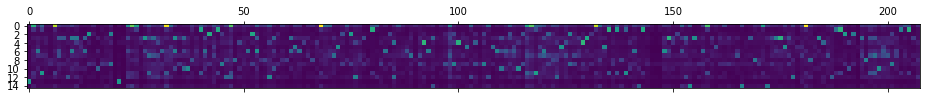

In [132]:
print(doc2topic)
plt.matshow(doc2topic.T)
#plt.colorbar()
plt.show()

### compute cosine similarity

In [ ]:
#vectorizer = TfidfVectorizer(max_df=0.5, min_df=0.01)
#tf_idf_matrix  = vectorizer.fit_transform(corpus_nouns)
#features = vectorizer.get_feature_names()
#tf_idf_matrix

In [133]:
pairwise_similarity = tf_idf_matrix * tf_idf_matrix.T 
similarity = pairwise_similarity.toarray()


In [ ]:
corpus.index('abbild')

### build network

In [67]:
doc2topic[0]

array([0.08697706, 0.00623353, 0.01884183, 0.02217894, 0.0624163 ,
       0.01183636, 0.01448063, 0.03335566, 0.02175573, 0.04090034,
       0.02129401, 0.03236882, 0.05090856, 1.1817996 , 0.00968233])

In [157]:
def build_top_graph(grouped, min_weight):

    nodes = []
    count = 1
    for tx,top in enumerate(grouped):
        if doc2topic[tx].max() > 0:
            numtopic = doc2topic[tx].argmax()
            nametopic = topic_list_ext[numtopic]
        else:
            numtopic = 16
            nametopic = 'nicht definiert'
            
        node_dict = {
            'id' : count,
            'top' : top,
            'date' : grouped[top][0]['date'],
            'nReden' : len(grouped[top]),
            'topic' : numtopic+1,
            'topicname' : nametopic
        }
        nodes.append(node_dict)
        count += 1
    
    
    graph = {
        'directed': False,
        'graph': 'semant_graph',
        'links': [],
        'nodes': nodes,
    }

    for ix,nodeI in enumerate(graph['nodes']):
        for jx,nodeJ in enumerate(graph['nodes']):
            if ix < jx:
                source = nodeI['id']
                target = nodeJ['id']
                #weight = cos_sim(nodeI['vec_numbers'], nodeJ['vec_numbers'])
                #r = np.corrcoef(nodeI['vec_numbers'], nodeJ['vec_numbers'])
                #weight = r[0,1]
                weight = similarity[ix,jx]
                weight = topic2topic[ix,jx]
                if weight > min_weight:
                    link_dict = {
                        'source':source,
                        'target':target,
                        'weight':weight       
                    }
                    graph['links'].append(link_dict)
    return graph

graph = build_top_graph(grouped, 0.8)
graph['nodes'][22]

{'id': 23,
 'top': 'Tagesordnungspunkt 5 2021-12-08',
 'date': '2021-12-08',
 'nReden': 16,
 'topic': 5,
 'topicname': 'kommune ganztagsbetreuung schule frist bildung fristverlängerung rechtsanspruch bund gesetzentwurf eltern'}

In [101]:
doc2topic[5]

array([0.13015681, 0.03016189, 0.04423484, 0.0459868 , 0.037225  ,
       0.02846034, 0.03877765, 0.03741313, 0.1654521 , 0.25609008,
       0.028304  , 0.02010312, 0.05822873, 0.02099673, 0.02571885])

### graph overview

This graph has 208 nodes and 2034 links.


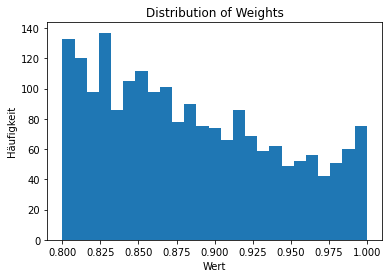

In [158]:
nn = len(graph['nodes'])
ne = len(graph['links'])
print( f"This graph has {nn} nodes and {ne} links.")

weights=[]
for link in graph['links']:
    weights.append(link['weight'])
#print(sum(weights))

plt.hist(weights, bins=25)
plt.title("Distribution of Weights")
plt.xlabel("Wert")
plt.ylabel("Häufigkeit")
plt.show()

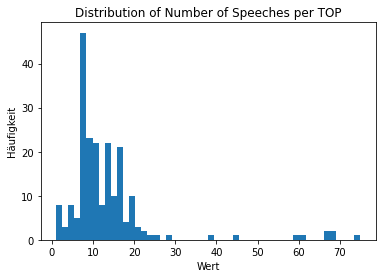

In [142]:
nReden=[]
for node in graph['nodes']:
    nReden.append(node['nReden'])
#print(sum(weights))

plt.hist(nReden, bins=50)
plt.title("Distribution of Number of Speeches per TOP")
plt.xlabel("Wert")
plt.ylabel("Häufigkeit")
plt.show()

### render graph to HTML

In [159]:
def GraphVisualizer(data, properties):
     
    #ncol, nlabel, darkmode, edgevisibility, particles
    
    nlabel = properties['nodelabel']
    ncol = properties['nodecoloring']
    nsize = properties['nodesize']
    
    # evaluate the boolean arguments
    if properties['edgevisibility'] == True:
        lv = "//"
    else:
        lv = ""
    if properties['particles'] == False:
        parts = "//"
    else:
        parts = ""
    if properties['darkmode'] == False:
        dm = "//"
    else:
        dm = ""
    
    d3graph = {"nodes": [], "links": []}
    d3graph["nodes"] = data["nodes"]
    d3graph["links"] = data["links"]

    htmlcode = f"""<head>
        <style> body {{margin: 0;}} </style>
        <script src="https://unpkg.com/force-graph"></script>
        <meta charset="UTF-8">
    </head>
    <body>
    <div id="graph"></div>
    <script>
        var data = {d3graph};
        const elem = document.getElementById('graph');
        const Graph = ForceGraph()(elem)
            .graphData(data)
            .nodeLabel('{nlabel}')
            .nodeRelSize(3)
            .nodeVal('nReden')
            .nodeAutoColorBy('{ncol}')
            {dm}.backgroundColor('#000000')
            {dm}.linkColor(() => 'rgba(255,255,255,0.2)')
            {lv}.linkVisibility('false')
            {parts}.linkDirectionalParticles(2)
            {parts}.linkDirectionalParticleWidth(1.4)
            .onNodeClick (node => {{window.open(`wordnet.html`, '_blank')}})
            //.onNodeHover(node => elem.style.cursor = node ? 'pointer' : null)
            .onNodeRightClick(node => {{
                // Center/zoom on node
                Graph.centerAt(node.x, node.y, 1000);
                Graph.zoom(4, 2000);
            }});
    </script>
    </body>
    """
    return {'graph':htmlcode}

In [160]:
properties = {
        'nodecoloring':'topic', 
        'nodelabel': 'topicname', 
        'nodesize': 'nReden',
        #'nodelabel': 'mfic',
        "darkmode": False,
        "edgevisibility": True,
        "particles": False
       }

#htmlgraph = GraphVisualizer(graph,'name','name',True,True,True)
htmlgraph = GraphVisualizer(graph,properties)

with open (f"./semanticnetworkTOPs.html", "w") as f:
    f.write(htmlgraph['graph'])

## Network of Topics


In [145]:
from sklearn.preprocessing import normalize



In [225]:
print(tf_idf_matrix.shape)
print(model.components_.shape)
#doc2topic = (tf_matrix * model.components_.T)
print(doc2topic.shape)

#base_matrix = normalize(doc2topic, axis=0, norm='l1')
base_matrix = normalize(model.components_, axis=1, norm='l1')
print(base_matrix.shape)

(208, 7434)
(15, 7434)
(208, 15)
(15, 7434)


In [226]:
print(base_matrix[0])

[0.00000000e+00 0.00000000e+00 8.59574869e-05 ... 1.19972967e-05
 5.01873376e-04 4.39154352e-04]


(15, 15)


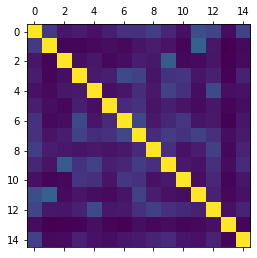

In [227]:
#topic2topic = base_matrix.T.dot(base_matrix)

from sklearn.metrics.pairwise import cosine_similarity
topic2topic = cosine_similarity(base_matrix)

print(topic2topic.shape)
#print(topic2topic)
plt.matshow(topic2topic)
#plt.colorbar()
plt.show()

In [228]:
nodes = []
count = 1
for tx,top in enumerate(topic2topic):
    node_dict = {
        'id' : count,
        'topicname' : topic_list_ext[tx]
    }
    nodes.append(node_dict)
    count += 1


graph = {
    'directed': False,
    'graph': 'semant_graph',
    'links': [],
    'nodes': nodes,
}

for ix,nodeI in enumerate(graph['nodes']):
    for jx,nodeJ in enumerate(graph['nodes']):
        if ix < jx:
            source = nodeI['id']
            target = nodeJ['id']
            weight = topic2topic[ix,jx]
            if weight > 0.15:
                link_dict = {
                    'source':source,
                    'target':target,
                    'weight':weight       
                }
                graph['links'].append(link_dict)

graph['nodes'][0]

{'id': 1,
 'topicname': 'russland putin waffe bundeskanzler friede präsident außenpolitik nato partner diplomatie'}

This graph has 15 nodes and 22 links.


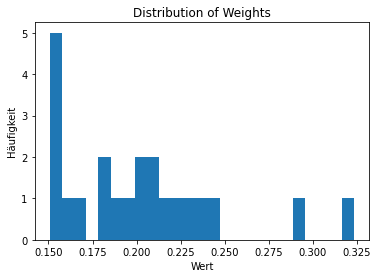

In [229]:
nn = len(graph['nodes'])
ne = len(graph['links'])
print( f"This graph has {nn} nodes and {ne} links.")

weights=[]
for link in graph['links']:
    weights.append(link['weight'])
#print(sum(weights))

plt.hist(weights, bins=25)
plt.title("Distribution of Weights")
plt.xlabel("Wert")
plt.ylabel("Häufigkeit")
plt.show()

In [230]:
properties = {
        'nodecoloring':'topicname', 
        'nodelabel': 'topicname', 
        'nodesize': 'nReden',
        #'nodelabel': 'mfic',
        "darkmode": False,
        "edgevisibility": True,
        "particles": False
       }

#htmlgraph = GraphVisualizer(graph,'name','name',True,True,True)
htmlgraph = GraphVisualizer(graph,properties)

with open (f"./semnetTopics.html", "w") as f:
    f.write(htmlgraph['graph'])

## Associated Word Network

(7434, 7434)


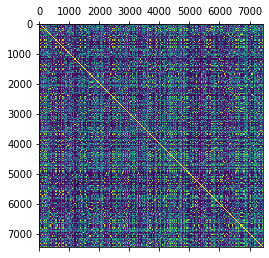

In [190]:

word2word = cosine_similarity(base_matrix.T)

print(word2word.shape)
plt.matshow(word2word)
#plt.colorbar()
plt.show()

In [216]:
nodes = []
count = 1
for wx,word in enumerate(word2word):
    
    if model.components_.T.max() > 0:
        numtopic = model.components_.T[wx].argmax()
        nametopic = topic_list_ext[numtopic]
    else:
        numtopic = 16
        nametopic = 'nicht definiert'
    
    node_dict = {
        'id' : count,
        'name' : feature_names[wx],
        'topic' : numtopic+1,
        'topicname' : nametopic
    }
    nodes.append(node_dict)
    count += 1


graph = {
    'directed': False,
    'graph': 'semant_graph',
    'links': [],
    'nodes': nodes,
}

for ix,nodeI in enumerate(graph['nodes']):
    for jx,nodeJ in enumerate(graph['nodes']):
        if ix < jx:
            source = nodeI['id']
            target = nodeJ['id']
            weight = word2word[ix,jx]
            if weight > 0.85:
                link_dict = {
                    'source':source,
                    'target':target,
                    'weight':weight       
                }
                graph['links'].append(link_dict)
                
nn = len(graph['nodes'])
ne = len(graph['links'])
print( f"This graph has {nn} nodes and {ne} links.") 

graph['nodes'][10]

This graph has 7434 nodes and 704793 links.


{'id': 11,
 'name': '20er',
 'topic': 8,
 'topicname': 'haushalt wirtschaft nachtragshaushalt investition schuldenbremse transformation schulde klimaschutz haushaltsentwurf digitalisierung'}

In [217]:
print(graph['nodes'][1000]  )
word2word[0]
model.components_.T[1000].argmax()

{'id': 1001, 'name': 'blaue', 'topic': 4, 'topicname': 'inflation entlastung einkommen preis progression rentner energiepreispauschale steuer umlage eeg'}


3

In [218]:
properties = {
        'nodecoloring':'topic', 
        'nodelabel': 'name', 
        'nodesize': 'topic',
        #'nodelabel': 'mfic',
        "darkmode": False,
        "edgevisibility": False,
        "particles": False
       }

#htmlgraph = GraphVisualizer(graph,'name','name',True,True,True)
htmlgraph = GraphVisualizer(graph,properties)

with open (f"./semnetWords.html", "w") as f:
    f.write(htmlgraph['graph'])